# Models Building in Sports - Part 2

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import some classes that I shamelessly borrowed from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
import sys
sys.path.insert(1, 'modules')
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import math

import random

%load_ext autoreload
%autoreload 2
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
pd.set_option("max_colwidth", 101)

## Read in the data, as we did before
We make use of Metrica_IO, Metrica_Viz, and Metrica_Velocities

In [2]:
# set up initial path to data
DATADIR = os.path.join("sample-data","data")
game_id = 2 # let's look at sample match 2

events = mio.read_event_data(DATADIR,game_id)
# Convert to a sane coordinate space
events = mio.to_metric_coordinates(events)

tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')
# Convert to a sane coordinate space
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

goalkeepers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

Reading team: home
Reading team: away


## Some generic helper functions

In [3]:
def build_grid(n_grid_cells_x):
    """Build a grid based on pitch dimensions and number of x cells passed.
    
    Parameters
    ----------
    n_grid_cells_x: int
        Number of cells per row in the x direction
    
    Returns
    -------
    tuple(Pitch Control for attacking team, defending team, xgrid, ygrid)
    
    """
    field_dimen=[106,68]
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
    # initialise pitch control grids for attacking/defending team
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    return PPCFa, PPCFd , xgrid, ygrid

In [4]:
x_cells = 120
PPCFa, PPCFd, xgrid, ygrid = build_grid(x_cells)

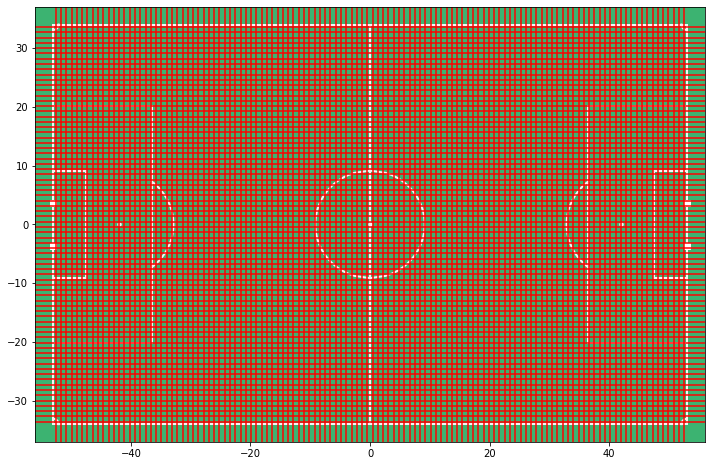

In [5]:
fig, ax= mviz.plot_pitch()
for y_line in ygrid:
    plt.axhline(y=y_line, color='r', linestyle='-')
for x_line in xgrid:
    plt.axvline(x=x_line, color='r', linestyle='-')

In [6]:
def plot_pitch_control(pitch_control_matrix,frame_of_interest_attacking_team, frame_of_interest,interpolation="spline36"):
    field_dimen=[106,68]
    fig, ax= mviz.plot_pitch(field_color="white")
    # plot pitch control surface
    if frame_of_interest_attacking_team=='Home':
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    mviz.plot_frame( tracking_home.loc[frame_of_interest], tracking_away.loc[frame_of_interest], figax=(fig,ax), PlayerAlpha=0.8, include_player_velocities=True, annotate=True )
    # For options see https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html 
    ax.imshow(np.flipud(pitch_control_matrix), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation=interpolation,vmin=0,vmax=1.0,cmap=cmap,alpha=0.38)
    return fig, ax

In [7]:
class player(object):
    """    
    Class defining a player object that stores position.
    
    Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    
    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected time_to_intercept
    
    """
    def __init__(self,pid,team,teamname,params,goalkeeper_id):
        self.id = pid
        self.is_gk = self.id == goalkeeper_id
        self.teamname = teamname
        self.vmax = params["vmax"] # m/s
        self.reaction_time = params["reaction_time"] # player reaction time in 's'.
        self.playername = "%s_%s_" % (teamname,pid)
        self.get_position(team)
        self.get_velocity(team)
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'x'], team[self.playername+'y'] ] )      

    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

In [8]:
def initialise_players(team,teamname,params,goalkeeper_id):
    """
    initialise_players(team,teamname,params)
    
    create a list of player objects that holds their positions and velocities from the tracking data dataframe 
    
    Parameters
    -----------
    
    team: row (i.e. instant) of either the home or away team tracking Dataframe
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returns
    -----------
    
    team_players: list of player objects for the team at at given instant
    
    """    
    # get player  ids
    player_ids = np.unique( [ c.split('_')[1] for c in team.keys() if c[:4] == teamname ] )
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player = player(p,team,teamname,params,goalkeeper_id)
        team_players.append(team_player)
    return team_players

In [9]:
def check_offsides( attacking_players, defending_players, ball_position, GK_numbers, verbose=False, tol=0.2):
    """
    check_offsides( attacking_players, defending_players, ball_position, GK_numbers, verbose=False, tol=0.2):
    
    checks whetheer any of the attacking players are offside (allowing for a 'tol' margin of error). Offside players are removed from 
    the 'attacking_players' list and ignored in the pitch control calculation.
    
    Parameters
    -----------
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_position: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
        verbose: if True, print a message each time a player is found to be offside
        tol: A tolerance parameter that allows a player to be very marginally offside (up to 'tol' m) without being flagged offside. Default: 0.2m
            
    Returrns
    -----------
        attacking_players: list of 'player' objects for the players on the attacking team with offside players removed
    """    
    # find jersey number of defending goalkeeper (just to establish attack direction)
    defending_GK_id = GK_numbers[1] if attacking_players[0].teamname=='Home' else GK_numbers[0]
    # make sure defending goalkeeper is actually on the field!
    assert defending_GK_id in [p.id for p in defending_players], "Defending goalkeeper jersey number not found in defending players"
    # get goalkeeper player object
    defending_GK = [p for p in defending_players if p.id==defending_GK_id][0]  
    # use defending goalkeeper x position to figure out which half he is defending (-1: left goal, +1: right goal)
    defending_half = np.sign(defending_GK.position[0])
    # find the x-position of the second-deepest defeending player (including GK)
    second_deepest_defender_x = sorted( [defending_half*p.position[0] for p in defending_players], reverse=True )[1]
    # define offside line as being the maximum of second_deepest_defender_x, ball position and half-way line
    offside_line = max(second_deepest_defender_x,defending_half*ball_position[0],0.0)+tol
    # any attacking players with x-position greater than the offside line are offside
    if verbose:
        for p in attacking_players:
            if p.position[0]*defending_half>offside_line:
                print("player %s in %s team is offside" % (p.id, p.playername) )
    attacking_players = [p for p in attacking_players if p.position[0]*defending_half<=offside_line]
    return attacking_players

In [10]:
params = {"vmax":5, "reaction_time":0.7}

In [11]:
event_id = 100
# event_id = 1
frame_of_interest = events.loc[event_id]['Start Frame']
frame_of_interest_attacking_team = events.loc[event_id].Team
ball_start_pos = np.array([events.loc[event_id]['Start X'],events.loc[event_id]['Start Y']])

if frame_of_interest_attacking_team=='Home':
    attacking_players = initialise_players(tracking_home.loc[frame_of_interest],'Home', params,goalkeepers[0])
    defending_players = initialise_players(tracking_away.loc[frame_of_interest],'Away', params,goalkeepers[1])
elif frame_of_interest_attacking_team=='Away':
    defending_players = initialise_players(tracking_home.loc[frame_of_interest],'Home',params, goalkeepers[0])
    attacking_players = initialise_players(tracking_away.loc[frame_of_interest],'Away',params, goalkeepers[1])
else:
    assert False, "Team in possession must be either home or away"

attacking_players = check_offsides( attacking_players, defending_players, ball_start_pos, goalkeepers)

## Basic Movement Model - assume equality throughout
If we assume equality for all players, it means whomever is closer to the ball will have ownership of it... let's build that

In [12]:
def pitch_control_function(target_position, attacking_players, defending_players):
    """A naive pitch control function - whomever is closest to target area claims ownership."""
        
    def distance_to_target(player):
        distance = np.linalg.norm(player-target_position)
        return distance
        
        
    min_distance_attacking_team = np.nanmin( [distance_to_target(p.position) for p in attacking_players] )
    min_distance_defending_team = np.nanmin( [distance_to_target(p.position) for p in defending_players] )
    
    if min_distance_attacking_team <= min_distance_defending_team:
        return 1
    else:
        return 0
        

In [13]:
# Now it's as simple as looping over each grid and calculating a value for it
    
for i in range( len(ygrid) ):
    for j in range( len(xgrid) ):
        target_position = np.array( [xgrid[j], ygrid[i]] )
        PPCFa[i,j] = pitch_control_function(target_position, attacking_players, defending_players)



(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

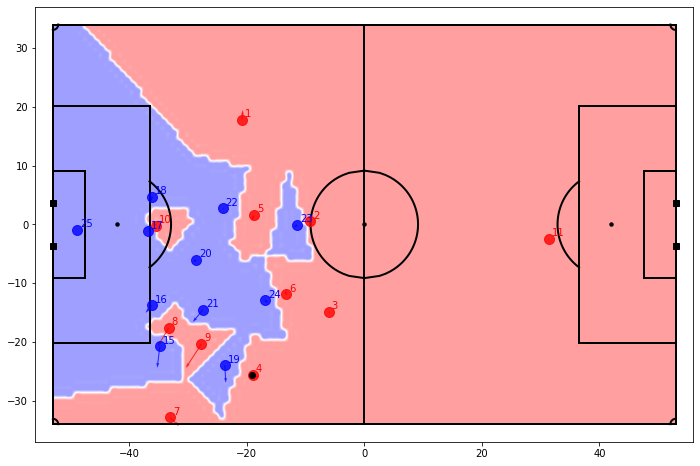

In [14]:
plot_pitch_control(PPCFa,frame_of_interest_attacking_team,frame_of_interest,interpolation="spline36")

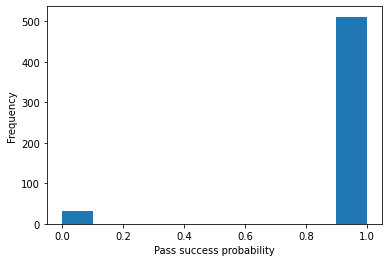

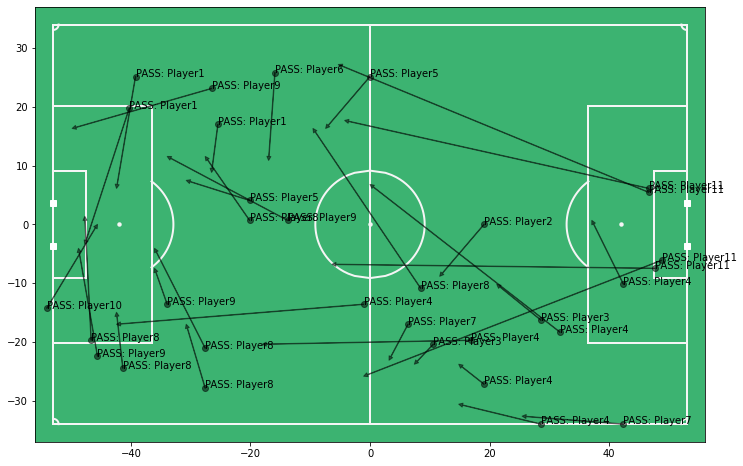

In [15]:
def plot_pass_probabilities(func):

# We can get the pass probabilites of all successful passes as a check
    pass_success_probability = []
    home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

    for i,row in home_passes.iterrows():
        pass_start_pos = np.array([row['Start X'],row['Start Y']])
        pass_target_pos = np.array([row['End X'],row['End Y']])
        pass_frame = row['Start Frame']

        attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params, goalkeepers[0])
        defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params, goalkeepers[1])
        Patt = func(pass_target_pos, attacking_players, defending_players)
        pass_success_probability.append( (i,Patt) )
    fig,ax = plt.subplots()
    ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
    ax.set_xlabel('Pass success probability')
    ax.set_ylabel('Frequency')  
    plt.show()
    
    
    # sort the passes by pitch control probability
    pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

    # identify the events corresponding to the most risky passes (pitch control < 0.5)
    risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

    # plot the events
    mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )
    plt.show()
    

plot_pass_probabilities(pitch_control_function)

What's interesting is that there's about 40 passes that are actually successful, that are classified as an extremely low proability of being successful

## What about just velocity?
What can we add? If we contextualise movement, something that seems important to me is a player's _current velocity_.
If we include velocity, then what we want to know is how long it will take a player to run from point A to point B. 

In [16]:
def pitch_control_function_velocity(target_position, attacking_players, defending_players):
    """A naive pitch control function - whomever get's to target area first - based solely on velocity - claims ownership."""
        
    min_time_attacking_team = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    min_time_defending_team = np.nanmin( [p.simple_time_to_intercept(target_position) for p in defending_players] )

    if min_time_attacking_team <= min_time_defending_team:
        return 1
    else:
        return 0
        

In [17]:
# Now it's as simple as looping over each grid and calculating a value for it
    
for i in range( len(ygrid) ):
    for j in range( len(xgrid) ):
        target_position = np.array( [xgrid[j], ygrid[i]] )
        PPCFa[i,j] = pitch_control_function_velocity(target_position, attacking_players, defending_players)



(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

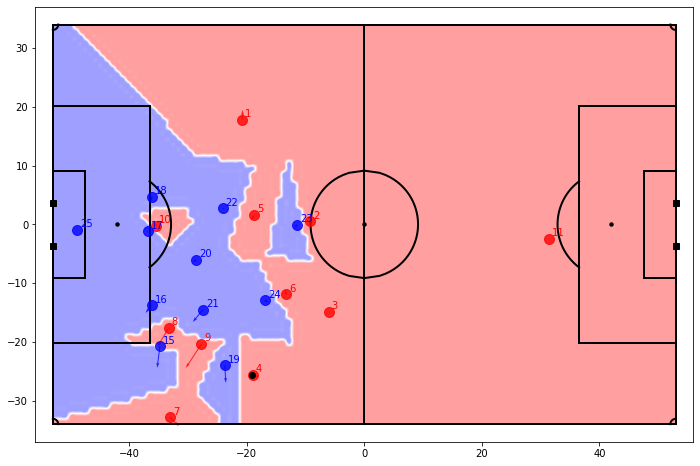

In [18]:
plot_pitch_control(PPCFa,frame_of_interest_attacking_team,frame_of_interest,interpolation="spline36")

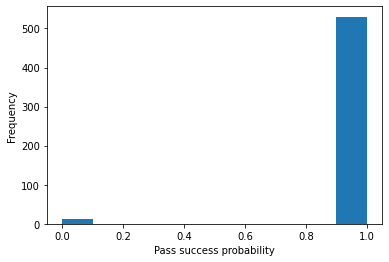

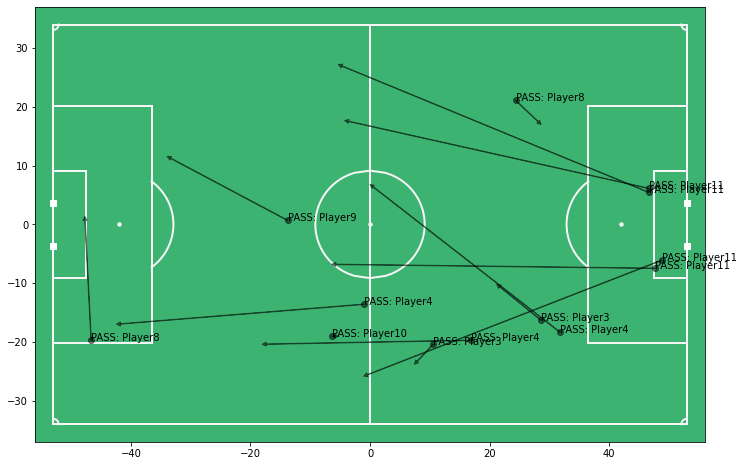

In [19]:
plot_pass_probabilities(pitch_control_function_velocity)

Interesting... while the pitch control map looks strange, we incorrectly classify less successful passes as a very low probability of succeeding?
What about unsuccessful passes?

How else can we tweak our model?

## Movement Model - account for more factors
Essentially https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial3_PitchControl.py 

In [20]:
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )
    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]


In [21]:
def initialise_players(team,teamname,params,goalkeeper_id):
    """
    initialise_players(team,teamname,params)
    
    create a list of player objects that holds their positions and velocities from the tracking data dataframe 
    
    Parameters
    -----------
    
    team: row (i.e. instant) of either the home or away team tracking Dataframe
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returns
    -----------
    
    team_players: list of player objects for the team at at given instant
    
    """    
    # get player  ids
    player_ids = np.unique( [ c.split('_')[1] for c in team.keys() if c[:4] == teamname ] )
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player = player(p,team,teamname,params,goalkeeper_id)
        if team_player.inframe:
            team_players.append(team_player)
    return team_players

In [22]:
def default_model_params(time_to_control_veto=3):
    """
    default_model_params()
    
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['lambda_gk'] = params['lambda_def']*3.0 # make goal keepers must quicker to control ball (because they can catch it)
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

In [23]:
class player(object):
    """
    player() class
    
    Class defining a player object that stores position, velocity, time-to-intercept and pitch control contributions for a player
    
    __init__ Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    
    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected time_to_intercept
    
    """
    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self,pid,team,teamname,params,GKid):
        self.id = pid
        self.is_gk = self.id == GKid
        self.teamname = teamname
        self.playername = "%s_%s_" % (teamname,pid)
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_att = params['lambda_att'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_def = params['lambda_gk'] if self.is_gk else params['lambda_def'] # factor of 3 ensures that anything near the GK is likely to be claimed by the GK
        self.get_position(team)
        self.get_velocity(team)
        self.PPCF = 0. # initialise this for later
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'x'], team[self.playername+'y'] ] )
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

In [24]:
params = default_model_params()

In [25]:
pass_frame = events.loc[event_id]['Start Frame']
pass_team = events.loc[event_id].Team
ball_start_pos = np.array([events.loc[event_id]['Start X'],events.loc[event_id]['Start Y']])
if pass_team=='Home':
    attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params,goalkeepers[0])
    defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params,goalkeepers[1])
elif pass_team=='Away':
    defending_players = initialise_players(tracking_home.loc[pass_frame],'Home',params,goalkeepers[0])
    attacking_players = initialise_players(tracking_away.loc[pass_frame],'Away',params,goalkeepers[1])
else:
    assert False, "Team in possession must be either home or away"

# find any attacking players that are offside and remove them from the pitch control calculation
attacking_players = check_offsides( attacking_players, defending_players, ball_start_pos, goalkeepers)

for i in range( len(ygrid) ):
    for j in range( len(xgrid) ):
        target_position = np.array( [xgrid[j], ygrid[i]] )
        value = random.uniform(0, 1)
        PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
#         PPCFa[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

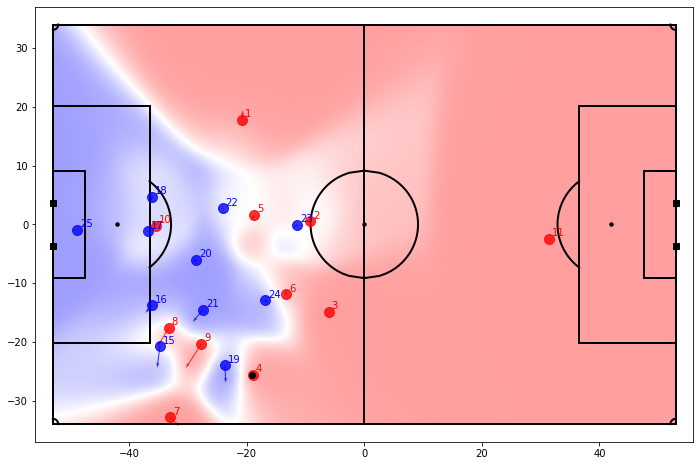

In [26]:
plot_pitch_control(PPCFa,frame_of_interest_attacking_team,frame_of_interest,interpolation="spline36")

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

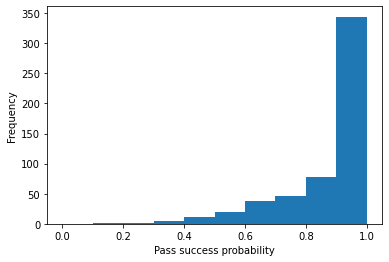

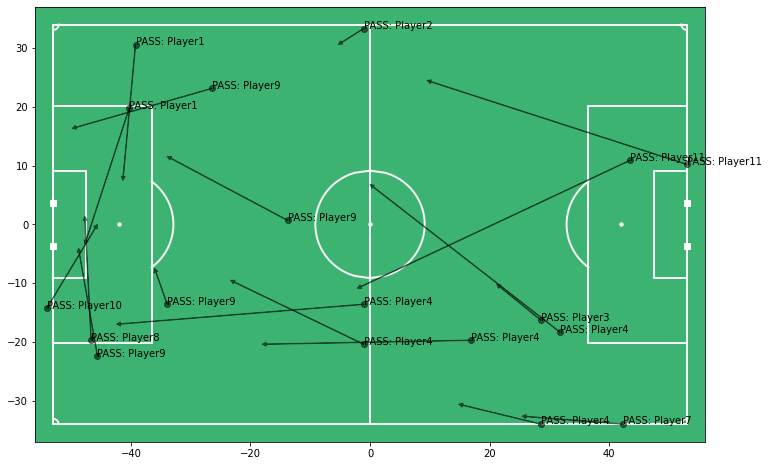

In [27]:
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params, goalkeepers[0])
    defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params, goalkeepers[1])
    Patt,Pdef = calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )
    
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )
